In [1]:
import csv
import numpy as np
#from random import shuffle
import cv2
import matplotlib.pyplot as plt
import os

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Cropping2D, Dropout, MaxPooling2D

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Import driving log
lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

In [3]:
lines[0][0]

'C:\\Users\\chapm\\Documents\\GitHub\\CarND-Behavioral-Cloning-P3\\data\\IMG\\center_2016_12_01_13_30_48_287.jpg'

In [23]:
image = cv2.cvtColor(cv2.imread(lines[250][0]), cv2.COLOR_BGR2RGB)

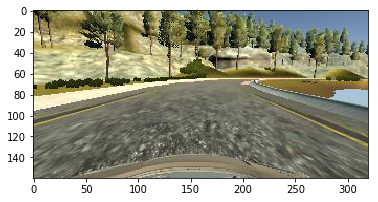

In [24]:
plt.imshow(image)

In [25]:
image.shape

(160, 320, 3)

In [26]:
image[70:(160-25), :, :].shape

(65, 320, 3)

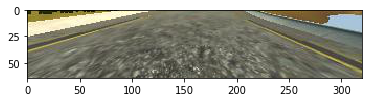

In [27]:
# crop and resize...
plt.imshow(image[70:(160-25), :, :])

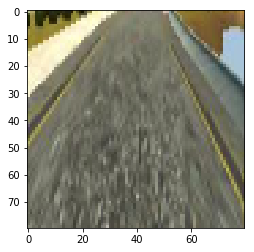

In [28]:
plt.imshow(cv2.resize(image[70:(160-25), :, :], (80, 80)))

In [29]:
# this one is trained vs udacity sample data...

import csv
import numpy as np
#from random import shuffle
import cv2
import matplotlib.pyplot as plt
import os

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Input, Convolution2D, Cropping2D, Dropout, MaxPooling2D

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from scipy.signal import filtfilt
from scipy.ndimage.filters import gaussian_filter1d

ignore_frames = [
'43_20_883.jpg',
'43_20_984.jpg',
'43_21_084.jpg', 
'43_21_187.jpg', 
'43_21_288.jpg', 
'43_21_390.jpg',
'43_21_492.jpg',
'43_21_595.jpg',
'43_21_696.jpg',
'43_21_799.jpg',
'43_21_900.jpg',
'43_22_002.jpg',
'43_22_102.jpg',
'43_22_203.jpg',
'43_22_305.jpg',
'43_22_406.jpg',
'43_22_508.jpg',
'43_22_610.jpg',
'43_22_713.jpg',
'43_22_814.jpg',
'43_22_916.jpg',
'43_23_019.jpg',
'43_23_121.jpg',
'43_23_223.jpg',
'43_23_325.jpg',
'43_23_427.jpg',
'43_23_529.jpg',
'43_23_631.jpg',
'43_23_733.jpg',
'43_23_836.jpg',
'43_23_936.jpg',
'43_24_034.jpg',
'43_24_141.jpg',
'43_24_242.jpg'
]

def check_ignore(x):
    for frame in ignore_frames:
        if x.endswith(frame):
            return False
    return True


lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:        
        if check_ignore(line[0]):
            lines.append(line)

images = []
measurements = []
for line in lines:
    source_path = line[0]
    image = cv2.imread(source_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)

augmented_images, augmented_measurements = [], []
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmented_measurements.append(measurement*-1.0)

# oversample
oversample_lines = []
with open('./data/driving_log_oversample.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        oversample_lines.append(line)

oversample_images, oversample_measurements = [], []
for line in oversample_lines:
    source_path = line[0]
    image = cv2.imread(source_path)
    oversample_images.append(image)
    measurement = float(line[3])
    oversample_measurements.append(measurement)

# add bridge to overwrite removed ones
# adding better turning
# adding aggressive turning...
bridge_lines = []
with open('./data/driving_log_bridge.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        bridge_lines.append(line)
        
with open('./turn-no-lines/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        bridge_lines.append(line)

with open('./aggressive-turn/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        bridge_lines.append(line)

bridge_images, bridge_measurements = [], []
for line in bridge_lines:
    source_path = line[0]
    image = cv2.imread(source_path)
    bridge_images.append(image)
    measurement = float(line[3])
    bridge_measurements.append(measurement)
    


In [30]:
X_train = np.array(augmented_images + oversample_images + bridge_images)
y_train = np.array(augmented_measurements + oversample_measurements + bridge_measurements)

In [39]:
from scipy.signal import convolve
from scipy.signal import butter, filtfilt

In [53]:
def butter_lowpass_filtfilt(data, cutoff=1000, fs=5000, order=5):    
    def butter_lowpass(cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a
    
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

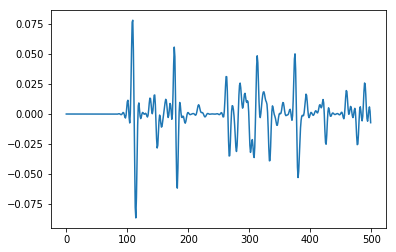

In [56]:
y_train_fix = butter_lowpass_filtfilt(y_train, 750)
plt.plot(range(500), y_train_fix[:500])

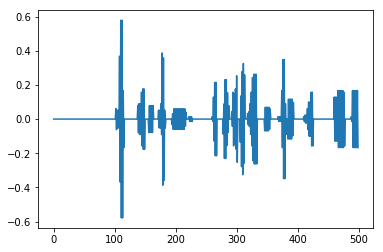

In [47]:
plt.plot(range(500), y_train[:500])

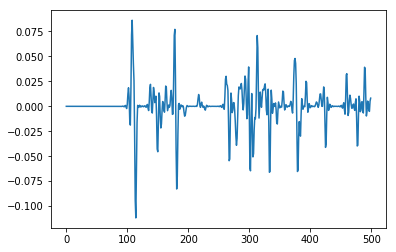

In [52]:
plt.plot(range(500), y_train_fix[:500])

In [4]:
images = []
measurements = []
for line in lines:
        source_path = line[0]
        image = cv2.imread(source_path)
        images.append(image)
        measurement = float(line[3])
        measurements.append(measurement)
        
X_train = np.array(images)
y_train = np.array(measurements)
        

In [5]:
#input_shape = (160, 320, 3)

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (160, 320, 3))) # normalise image
model.add(Cropping2D(cropping=((70,25), (0,0))))
model.add(Convolution2D(24, 5, 5, subsample(2,2), activation="relu"))
model.add(Convolution2D(36, 5, 5, subsample(2,2), activation="relu"))
model.add(Convolution2D(48, 5, 5, subsample(2,2), activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
model.add(Dropout(0.25))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True)

Train on 2191 samples, validate on 548 samples
Epoch 1/10
2191/2191 [==============================] - 2s - loss: 8223387.5170 - val_loss: 33259.7547
Epoch 2/10
2191/2191 [==============================] - 3s - loss: 11649.5325 - val_loss: 3927.3789
Epoch 3/10
2191/2191 [==============================] - 2s - loss: 3322.7487 - val_loss: 2517.9338
Epoch 4/10
2191/2191 [==============================] - 2s - loss: 2576.0675 - val_loss: 2215.3421
Epoch 5/10
2191/2191 [==============================] - 2s - loss: 3041.4673 - val_loss: 9169.8623
Epoch 6/10
2191/2191 [==============================] - 2s - loss: 2291.1914 - val_loss: 1994.0268
Epoch 7/10
2191/2191 [==============================] - 2s - loss: 1829.6923 - val_loss: 1538.6654
Epoch 8/10
2191/2191 [==============================] - 3s - loss: 1556.9918 - val_loss: 2748.3898
Epoch 9/10
2191/2191 [==============================] - 3s - loss: 1983.2264 - val_loss: 1515.9838
Epoch 10/10
2191/2191 [==============================] - 

In [6]:
model.save('model.h5')